This notebook examines how genre list length correlates with gender.

The model that looks to be statistically significant splits the data into two bins: length $\leq 5$ and length $\geq 6$. For each bin, calculate
$$\frac{\text{actual # of male artists in bin}}{\text{expected # of male artists in bin}}$$
where the expected number of male artists in a bin is ${\% \text{male in total sample} \cdot \text{total in bin}}$. For the first bin, with the number of genre labels $\leq 5$, the ratio is $1$ within expected error rates. However, for the second bin, male artists are over represented and female artists are under represented.


In [8]:
import numpy as np
import pandas as pd

seed = 23

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline
#%matplotlib notebook

from sklearn.model_selection import KFold

import re

from functools import partial

import plotly.graph_objects as go

from nested_subsets import NestedSubsets

Import the cleaned data:

In [9]:
%store -r now

X_train = pd.read_csv('/Users/Daniel/Code/Genre/data/genre_lists/data_ready_for_model/wiki-kaggle_X_train_{}.csv'.format(now), index_col = ['artist'])
y_train = pd.read_csv('/Users/Daniel/Code/Genre/data/genre_lists/data_ready_for_model/wiki-kaggle_y_train_{}.csv'.format(now), index_col = ['artist'])

data = y_train.join( [X_train], how = 'outer')

### Genre Labels

Each value of the genre column is a _string_ of comma separated genre labels. We want to convert it to a _list_ of strings.

In [10]:
"""This function takes in a string of the form
appearing in the genrelist of the dataframe.
It strips the square brackets and extra quotes and
returns a list of strings where each string is a genre label."""
def genrelist(string):
    string = string.strip("[").strip("]").replace("'","")
    L = [s for s in string.split(',')]
    L_new = []
    for x in L:
        L_new.append(x.replace(" ","_").lstrip("_").rstrip("_"))
    while (str("") in L_new):
        L_new.remove("")
    return L_new

Now we apply it to the whole column and put the lists in a new column:

In [11]:
data['genrelist']= data['genrelist'].apply(genrelist)

### Import the labels from the whole data set:

In [12]:
genrelist_df = pd.read_csv('/Users/Daniel/Code/Genre/data/genre_lists/data_ready_for_model/genre_list_{}.csv'.format(now), index_col = 'Unnamed: 0')

In [13]:
data_male = data[data.gender == 'male']
data_female = data[data.gender == 'female']

In [14]:
tot = data.shape[0]
mal = data_male.shape[0]
fem = data_female.shape[0]
print('{} total artists'.format(tot))
print('There are {} unique genre labels.'.format(genrelist_df.shape[0]))
print('{} female artists, or {:0.0f}%'.format(fem, 100*fem/(fem+mal)))
print('{} male artists, or {:0.0f}%'.format(mal, 100*mal/(fem+mal)))

12376 total artists
There are 1494 unique genre labels.
3847 female artists, or 31%
8529 male artists, or 69%


## Calculate ratios of actual to expected for male and female using two bins for list lengths: <6 and >5 

### This function creates a DF with the frequencies of the lengths of lists by gender for a df of the type of "data" above. It is used in the bin_cv_est function below.

In [15]:
def create_length_counts_by_gender(df):
    """df is """
    
    #length counts total
    dft = df.groupby(['genrelist_length']).count()
    dft.drop(['gender'], axis = 1, inplace = True)
    dft.columns = ['artist_count']
    
    # length counts by gender
    df = df.groupby(['genrelist_length','gender']).count()
    df.columns = ['artist_count']

    df.reset_index(inplace = True)
    df.set_index(['genrelist_length'], inplace = True)
    df = df.pivot(columns = 'gender')
    
    #flatten index and replace with single strings
    df.columns = df.columns.to_flat_index()
    df.columns = [name[1] for name in df.columns]
    #combine total count with gender counts
    dft.columns = ['total']
    df = dft.join(df, how = 'outer')
    
    df.fillna(value = {'female': 0}, inplace = True)
    
    return df

In [16]:
lcbg = create_length_counts_by_gender(data)

### The bin_est function estimates actual/expected ratios for male and female by genre list length by binning the data into < 6 and > 5 bins.

In [17]:
def bin_est(df):
    
    # create length counts by gender
    lcbg = create_length_counts_by_gender(df)

    # mark rows by their class (uses ordering; could be done with masking)
    lcbg['classify'] = '1-5'
    lcbg.iloc[6:,-1] = '>5'

    # calculate totals for each bin
    twobins = lcbg.groupby(['classify']).agg('sum')

    # calculated columns: expected and ratios 
    twobins['expected female'] = (.31*twobins['total']).astype('int64')
    twobins['expected male'] = (.69*twobins['total']).astype('int64')
    twobins['male_act_exp_ratio'] =twobins['male']/ twobins['expected male']
    twobins['female_act_exp_ratio'] =  twobins['female']/ twobins['expected female']

    # only keep needed columns
    twobins = twobins[['female_act_exp_ratio','male_act_exp_ratio']]

    return twobins

Calculate twobin biases for nested subsets over multiple runs (random selection of subsets). Store the results and calculate the mean and std for each size over the runs.

In [28]:
# set the number of runs
k = 100

# Set percentage or step_size; step_size overrides percentage
percentage = .05
step_size = None

# initialize a DataFrame to save biases calculated for each nested subsample
# call NestedSubsets to get the_number_of_subsets and step_size
subsets = NestedSubsets(data, step_size, percentage = percentage)
number_of_steps = subsets.get_number_of_steps()
step_size = subsets.get_step_size()

# create list of sizes of subsets to use as level in MultiIndex
sizes = [data.shape[0]-j*step_size for j in range(number_of_steps)]

# create empty DF with MultiIndex
indices = [sizes, ['1-5','>5']]
columns = [[f'run_{i}' for i in range(k)], ['female_act_exp_ratio','male_act_exp_ratio']]
biases = pd.DataFrame(index = pd.MultiIndex.from_product(indices), columns = pd.MultiIndex.from_product(columns), dtype = float)
biases.index.names = ['size','bin']
biases.columns.names = ['runs','gender']

# define slicer for accessing slices of multi-indexed DF
idx = pd.IndexSlice

for i in range(k): # perform k runs
    # create the subset generator
    subsets = NestedSubsets(data, step_size, percentage = percentage)
    # get the step_size from the subset generator
    step_size = subsets.get_step_size()
    
    # loop through subsets
    for subset in subsets:
        size = subset.shape[0]
        if size >= step_size: # excluding the remainder samples
            twobins = bin_est(subset) # calculate biases
            
            # set indices of twobins to match the slice of relevant biases 
            indices = [[size],['1-5', '>5']]
            columns = [[f'run_{i}'],['female_act_exp_ratio','male_act_exp_ratio']]
            twobins.index = pd.MultiIndex.from_product(indices)
            twobins.columns = pd.MultiIndex.from_product(columns)
            
            # set values
            biases.loc[idx[[size],['1-5', '>5']],idx[[f'run_{i}'],['female_act_exp_ratio','male_act_exp_ratio']]] = twobins

biases.sort_index(ascending = False)
means = biases.groupby(['gender'], axis = 1).mean()
means.columns = pd.MultiIndex.from_product([['means'],['fem mean','mal mean']])
stds = biases.groupby(['gender'], axis = 1).std()
stds.columns = pd.MultiIndex.from_product([['stds'],['fem std','mal std']])
biases = biases.join([means, stds])

Show a plot of the biases over multiple runs

In [46]:
biases.iloc[-6:]

runs                    run_0                                   run_1  \
gender   female_act_exp_ratio male_act_exp_ratio female_act_exp_ratio   
size bin                                                                
1870 1-5             0.958929           1.019246             1.054770   
     >5              0.473684           1.261905             0.615385   
1252 1-5             0.970509           1.014440             1.047493   
     >5              0.428571           1.281250             0.750000   
634  1-5             0.941176           1.028846             1.021053   
     >5              0.333333           1.350000             0.400000   

runs                                       run_2                     \
gender   male_act_exp_ratio female_act_exp_ratio male_act_exp_ratio   
size bin                                                              
1870 1-5           0.976190             1.042629           0.981644   
     >5            1.206897             0.312500           1.333333   
1252 1-5           0.979834             1.002646           1.000000   
     >5            1.150000             0.333333           1.350000   
634  1-5           0.992941             0.953125           1.023310   
     >5            1.333333             0.666667           1.250000   

runs                    run_3                                   run_4  \
gender   female_act_exp_ratio male_act_exp_ratio female_act_exp_ratio   
size bin                                                                
1870 1-5             1.030303           0.987200             0.989362   
     >5              0.588235           1.200000             0.333333   
1252 1-5             1.018667           0.992823             0.997347   
     >5              0.833333           1.111111             0.400000   
634  1-5             1.000000           1.002381             0.957895   
     >5              0.857143           1.125000             0.200000   

runs                         ...               run_97                     \
gender   male_act_exp_ratio  ... female_act_exp_ratio male_act_exp_ratio   
size bin                     ...                                           
1870 1-5           1.005578  ...             1.012456           0.995200   
     >5            1.323529  ...             0.529412           1.230769   
1252 1-5           1.002381  ...             1.010638           0.996420   
     >5            1.304348  ...             0.363636           1.320000   
634  1-5           1.021176  ...             1.036842           0.985816   
     >5            1.416667  ...             0.000000           1.538462   

runs                   run_98                                  run_99  \
gender   female_act_exp_ratio male_act_exp_ratio female_act_exp_ratio   
size bin                                                                
1870 1-5             1.026690           0.988827             1.053476   
     >5              0.437500           1.270270             0.529412   
1252 1-5             0.984127           1.008314             1.000000   
     >5              0.555556           1.238095             0.545455   
634  1-5             1.073298           0.969484             0.957895   
     >5              0.750000           1.181818             1.200000   

runs                            means                stds            
gender   male_act_exp_ratio  fem mean  mal mean   fem std   mal std  
size bin                                                             
1870 1-5           0.976800  1.016090  0.993573  0.031107  0.013966  
     >5            1.225000  0.557254  1.223406  0.164114  0.073034  
1252 1-5           1.001195  1.015198  0.994370  0.036828  0.016532  
     >5            1.230769  0.564240  1.234507  0.198545  0.088732  
634  1-5           1.021226  1.019665  0.993538  0.057049  0.025593  
     >5            1.000000  0.554448  1.282392  0.329713  0.150849  

[6 rows x 204 columns]

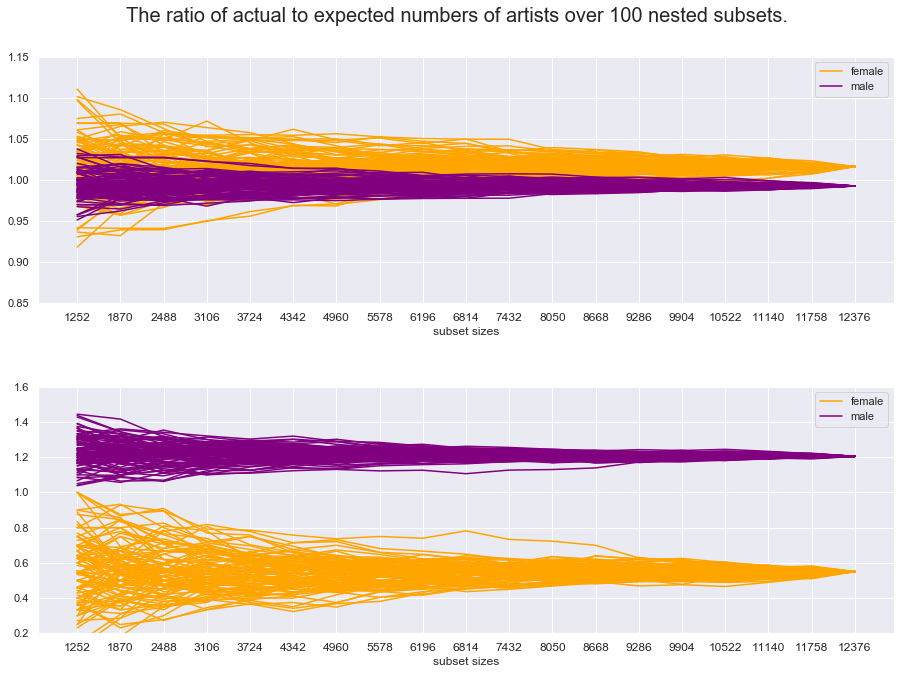

In [56]:
# plot the paths for the runs of each nested subsets
fig, axs = plt.subplots(2,1, figsize = (14,10))
fig.suptitle('The ratio of actual to expected numbers of artists over 100 nested subsets.', fontsize = 20)
fig.tight_layout(pad = 6.0)

idx = pd.IndexSlice
# the data set
df = biases
df.sort_index(ascending = False) # needed for slicing

# x-values for paths
runs_index = np.flip(df.loc[idx[:,'1-5'],:].index.get_level_values(0).values)
runs_index = runs_index[1:] # leave off the remainder subset

# generate arrays in which each row is a run, from small subset to large
fem_small_runs = np.stack([np.flip(df.loc[ idx[:,'1-5'], idx[[f'run_{i}'],['female_act_exp_ratio']] ].values.flatten()) for i in range(k)])
mal_small_runs = np.stack([np.flip(df.loc[ idx[:,'1-5'], idx[[f'run_{i}'],['male_act_exp_ratio']] ].values.flatten()) for i in range(k)])
fem_large_runs = np.stack([np.flip(df.loc[ idx[:,'>5'], idx[[f'run_{i}'],['female_act_exp_ratio']] ].values.flatten()) for i in range(k)])
mal_large_runs = np.stack([np.flip(df.loc[ idx[:,'>5'], idx[[f'run_{i}'],['male_act_exp_ratio']] ].values.flatten()) for i in range(k)])

# drop first value which is for the remainder set
fem_small_runs = fem_small_runs[:,1:]
mal_small_runs = mal_small_runs[:,1:]
fem_large_runs = fem_large_runs[:,1:]
mal_large_runs = mal_large_runs[:,1:]

# plot paths
for i in range(k):
    axs[0].plot(runs_index,fem_small_runs[i], color = 'orange', label = f'fem_small_runs_{i}' )

for i in range(k):
    axs[0].plot(runs_index,mal_small_runs[i], color = 'purple', label = f'mal_small_runs_{i}')
    
for i in range(k):
    axs[1].plot(runs_index,fem_large_runs[i], color = 'orange', label = f'fem_large_runs_{i}')

for i in range(k):
    axs[1].plot(runs_index,mal_large_runs[i], color = 'purple', label = f'mal_large_runs_{i}')

# y range
axs[0].set_ylim(bottom = .85, top = 1.15)
axs[1].set_ylim(bottom = .2,top = 1.6)

# set xticklabels; flip so order is small to large, as above
xticklabels = runs_index
xlabel_pos = runs_index # set the positions for labels

# styling
axs[0].set_xticks(xlabel_pos)
axs[0].set_xticklabels(xticklabels, fontsize = 12, rotation = 0)
axs[1].set_xticks(xlabel_pos)
axs[1].set_xticklabels(xticklabels, fontsize = 12, rotation = 0)
axs[0].set_xlabel('1-5 genre labels'.title(), fontsize = 16)
axs[1].set_xlabel('6 or more genre labels'.title(), fontsize = 16)
axs[0].set_xlabel('subset sizes', fontsize = 12)
axs[1].set_xlabel('subset sizes', fontsize = 12)

handles, labels = axs[0].get_legend_handles_labels()
axs[0].legend(handles = [handles[0], handles[k]], labels = ['female', 'male'])
handles, labels = axs[1].get_legend_handles_labels()
axs[1].legend(handles = [handles[0], handles[k]], labels = ['female', 'male'])

In [57]:
fig.savefig('/Users/Daniel/Code/Genre/visualizations/twobin_paths.png')

The significance of the geometry of the paths is that the bias for f/m with >5 labels is safely away from 1.0 even when only half of the data is used and that the paths oscillate around a line of zero slope. If they oscillated around a curve that had non-zero slope at the full data set, that would have suggested that the data had not captured the full distribution. The convergence to the same point is of no significance: at (12376, the full data set) all paths use the same data for the bias estimate.

Plot the mean and std over the runs for each subset set 

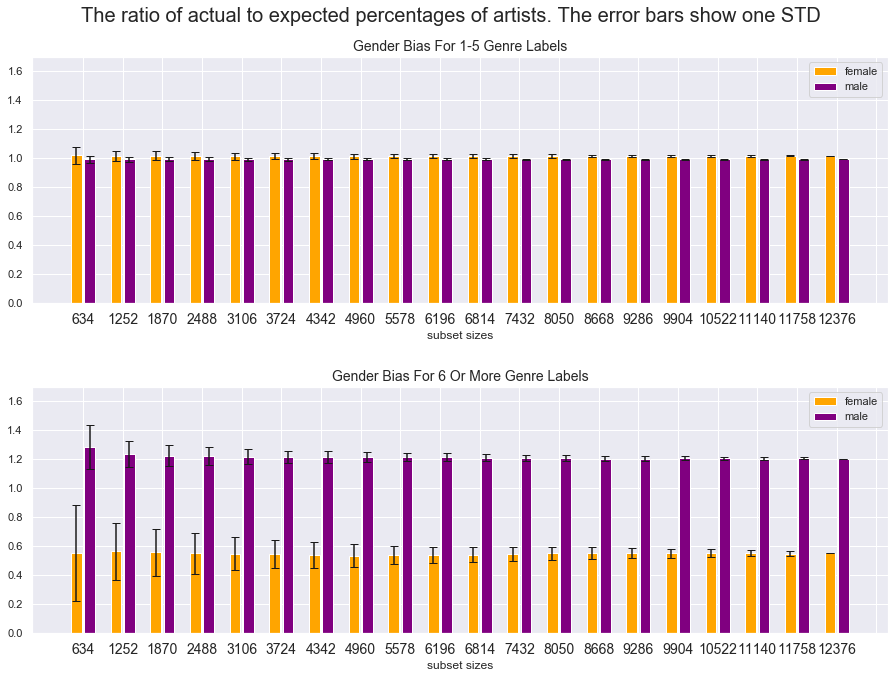

In [58]:
idx = pd.IndexSlice
df = biases
# extract lists of values for the means of each category
# flip arrays so that subset size increases left to right
df_fem_small = np.flip(df.loc[ idx[:,'1-5'], idx[['means'],['fem mean']] ].values.flatten())
df_fem_large = np.flip(df.loc[ idx[:,'>5'], idx[['means'],['fem mean']] ].values.flatten())
df_mal_small = np.flip(df.loc[ idx[:,'1-5'], idx[['means'],['mal mean']] ].values.flatten())
df_mal_large = np.flip(df.loc[ idx[:,'>5'], idx[['means'],['mal mean']] ].values.flatten())

# extract the stds
eb_fem_small = np.flip(df.loc[ idx[:,'1-5'], idx[['stds'],['fem std']] ].values.flatten())
eb_fem_large = np.flip(df.loc[ idx[:,'>5'], idx[['stds'],['fem std']] ].values.flatten())
eb_mal_small = np.flip(df.loc[ idx[:,'1-5'], idx[['stds'],['mal std']] ].values.flatten())
eb_mal_large = np.flip(df.loc[ idx[:,'>5'], idx[['stds'],['mal std']] ].values.flatten())

# indices for bars
number_of_bars = len(df_fem_small)
ind_fem = np.arange(0,3*number_of_bars,3)
ind_mal = np.arange(1,3*number_of_bars+1,3)
xlabel_pos = np.arange(0,3*number_of_bars+1,3)+.5

# set xticklabels; flip so order is small to large, as above
xticklabels = np.flip(df.loc[idx[:,'1-5'],:].index.get_level_values(0).values)

fig, axs = plt.subplots(2,1, sharey = True, figsize = (14,10))
fig.tight_layout(pad = 6.0)
fig.suptitle('The ratio of actual to expected percentages of artists. The error bars show one STD', fontsize = 20)
axs[0].bar(ind_fem,df_fem_small, color = 'orange', yerr = eb_fem_small, capsize = 4, label = 'female')
axs[0].bar(ind_mal,df_mal_small, color = 'purple', yerr = eb_mal_small, capsize = 4, label = 'male')
axs[1].bar(ind_fem,df_fem_large, color = 'orange', yerr = eb_fem_large, capsize = 4, label = 'female')
axs[1].bar(ind_mal,df_mal_large, color = 'purple', yerr = eb_mal_large, capsize = 4, label = 'male')

# y range
axs[0].set_ylim(0,1.7)
axs[1].set_ylim(0,1.7)

# styles
axs[0].set_title('Gender Bias for 1-5 genre labels'.title(), fontsize = 14)
axs[1].set_title('Gender Bias for 6 or more genre labels'.title(), fontsize = 14)

axs[0].set_xticks(xlabel_pos)
axs[0].set_xticklabels(xticklabels, fontsize = 14, rotation = 0)
axs[1].set_xticks(xlabel_pos)
axs[1].set_xticklabels(xticklabels, fontsize = 14, rotation = 0)
axs[0].set_xlabel('subset sizes', fontsize = 12)
axs[1].set_xlabel('subset sizes', fontsize = 12)
axs[0].legend()
axs[1].legend()

In [60]:
fig.savefig('/Users/Daniel/Code/Genre/visualizations/twobin_means.png')